This code is a result of a recent research on portfolio theory. One can see the paper

 ***Halidias, Nikolaos. "A novel portfolio optimization method and its application to the hedging problem" Monte Carlo Methods and Applications, vol. 30, no. 3, 2024, pp. 249-267,*** and the references therein. (https://www.degruyterbrill.com/document/doi/10.1515/mcma-2024-2009/html)

See also the book
***Halidias, Nikolaos and Stamatiou, Ioannis S.. Stochastic Analysis: Financial Mathematics with Matlab®, De Gruyter, 2026.*** (https://www.degruyterbrill.com/document/isbn/9783111443737/html?lang=en&srsltid=AfmBOorukbLCPRdRPn2Mu2kqSWiGttsEAPF6wBfVNixx4fAFzxycr6Fl)

At the webpage of the ***Actuarial-Financial Laboratory*** https://www.samos.aegean.gr/actuar/nick/actfinlabeng.htm one can find also other useful informations.



We use all the call and put options from the yahoo finace in order to construct the portfolio. If you choose experiment=1 then we use the lastPrices otherwise the bid-ask prices. If for any reason you want to take account only some of the call and put options you should manually set the data stock_value, call_strikes,put_strikes,call_ask,call_bid,put_ask,put_bid.




In practice, before the expiration you should have:

1.   The amount 100*strike price for each call you have bought
2.   100 shares for each call that you have sell
3.   100 shares for each put that you have bought
4.   The amount 100*strike price for each put that you have sell



If you want to download data from Yahoo finance you should set Data_given=1. Otherwise you should have an excel file from which the data will be stored.

MILP Arbitrage with Bank Account (Colab)
Ticker (π.χ. AAPL): AAPL
1: Yahoo Finance, 0: Excel: 1
0: bid/ask, 1: lastPrice: 0
risk-free r (% ετησίως): 1
Expirations:
1. 2025-09-19
2. 2025-09-26
3. 2025-10-03
4. 2025-10-10
5. 2025-10-17
6. 2025-10-24
7. 2025-11-21
8. 2025-12-19
9. 2026-01-16
10. 2026-02-20
11. 2026-03-20
12. 2026-04-17
13. 2026-05-15
14. 2026-06-18
15. 2026-08-21
16. 2026-09-18
17. 2026-12-18
18. 2027-01-15
19. 2027-06-17
20. 2027-12-17
Επιλογή #: 19
Διαταραχή; 1: όχι, 2: (ask +x%, bid -x%): 1
Max κατάθεση (≥0): 1000
Max δανεισμός (≥0): 1000
+---------------+------------+--------------------+------------------+
|     Asset     | Qty/Amount |     Unit/Info      | Initial Cashflow |
+---------------+------------+--------------------+------------------+
| AAPL (Shares) |    4.0     |    Spot=234.07     |    936.280029    |
|  Bank account | 750.619971 | g=(1+r)^T=1.017628 |    750.619971    |
+---------------+------------+--------------------+------------------+
+-----------

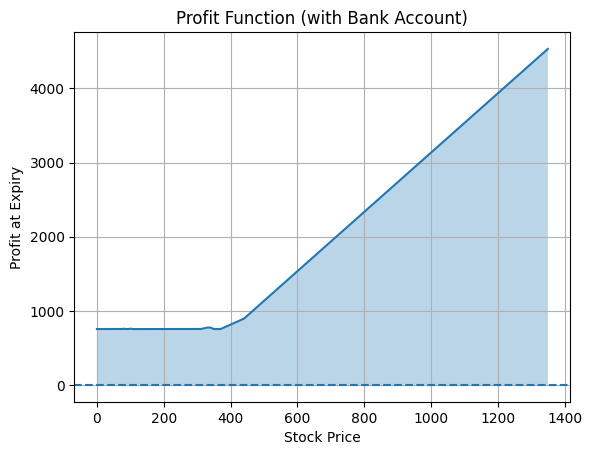

In [22]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
MILP για (πιθανό) arbitrage με μετοχή, options (calls/puts) και bank account
(κατάθεση ή δανεισμός) — έτοιμο για Google Colab.

ΝΕΟ (tail safety):
- Προστέθηκε **φρουρός κλίσης στο +∞**: shares + Σ(call_buy) − Σ(call_sell) ≥ 0,
  ώστε το payoff να μην κατεβαίνει ξανά για πολύ μεγάλα S.
- Προστέθηκε και **έλεγχος σε μεγάλο S_high** στο πλέγμα payoff constraints,
  για επιπλέον ασφάλεια. Έτσι το γράφημα δεν θα παίρνει αρνητικές τιμές σε υψηλά S,
  όταν δηλώνεται εγγυημένο κέρδος (−z ≥ 0).

Σειρά μεταβλητών:
[call_buy(m), call_sell(m), put_buy(n), put_sell(n), shares, bank, z]

Απαιτήσεις: numpy, pandas, yfinance, scipy>=1.9, prettytable, matplotlib
"""

from __future__ import annotations

import sys
from datetime import datetime, UTC
from typing import Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import yfinance as yf
except Exception:
    yf = None

from scipy.optimize import LinearConstraint, Bounds, milp
from prettytable import PrettyTable

# ------------------------------
# ΡΥΘΜΙΣΕΙΣ
# ------------------------------
V = 0
max_number_of_total_call_options_to_buy = 40
max_number_of_total_put_options_to_buy = 40
max_number_of_total_call_options_to_sell = 40
max_number_of_total_put_options_to_sell = 40
max_number_of_call_options_to_buy = 2
max_number_of_put_options_to_buy = 2
max_number_of_call_options_to_sell = 2
max_number_of_put_options_to_sell = 2
max_number_of_shares_to_buy = 100
max_number_of_shares_to_sell = 100

# ------------------------------
# ΔΕΔΟΜΕΝΑ
# ------------------------------

def fetch_options_from_yf(ticker: str, expiration: str, use_last: bool):
    if yf is None:
        raise RuntimeError("Το yfinance δεν είναι διαθέσιμο σε αυτό το περιβάλλον.")
    stock = yf.Ticker(ticker)
    hist = stock.history(period="5d").get("Close", pd.Series(dtype=float)).dropna()
    if hist.empty:
        raise RuntimeError("Αδύνατη η λήψη τελευταίας τιμής μετοχής.")
    spot = float(hist.iloc[-1])

    chain = stock.option_chain(expiration)
    calls = chain.calls[["strike", "lastPrice", "bid", "ask"]].copy()
    puts = chain.puts[["strike", "lastPrice", "bid", "ask"]].copy()

    if use_last:
        calls["use_ask"] = calls["lastPrice"]
        calls["use_bid"] = calls["lastPrice"]
        puts["use_ask"] = puts["lastPrice"]
        puts["use_bid"] = puts["lastPrice"]
    else:
        calls["use_ask"] = calls["ask"]
        calls["use_bid"] = calls["bid"]
        puts["use_ask"] = puts["ask"]
        puts["use_bid"] = puts["bid"]

    calls = calls.dropna(subset=["strike", "use_ask", "use_bid"]).query("use_ask>0 and use_bid>0").sort_values("strike")
    puts = puts.dropna(subset=["strike", "use_ask", "use_bid"]).query("use_ask>0 and use_bid>0").sort_values("strike")

    call_strikes = calls["strike"].to_numpy(float)
    put_strikes = puts["strike"].to_numpy(float)
    call_ask = calls["use_ask"].to_numpy(float)
    call_bid = calls["use_bid"].to_numpy(float)
    put_ask = puts["use_ask"].to_numpy(float)
    put_bid = puts["use_bid"].to_numpy(float)

    return spot, call_strikes, put_strikes, call_ask, call_bid, put_ask, put_bid


def fetch_options_from_excel(path: str, use_last: bool):
    df = pd.read_excel(path)
    spot = float(pd.to_numeric(df.iloc[0, 0], errors="coerce"))

    call_strikes = pd.to_numeric(df.iloc[:, 1], errors="coerce").dropna()
    put_strikes = pd.to_numeric(df.iloc[:, 5], errors="coerce").dropna()

    if use_last:
        call_ask = pd.to_numeric(df.iloc[:, 2], errors="coerce")
        call_bid = pd.to_numeric(df.iloc[:, 2], errors="coerce")
        put_ask = pd.to_numeric(df.iloc[:, 6], errors="coerce")
        put_bid = pd.to_numeric(df.iloc[:, 6], errors="coerce")
    else:
        call_ask = pd.to_numeric(df.iloc[:, 4], errors="coerce")
        call_bid = pd.to_numeric(df.iloc[:, 3], errors="coerce")
        put_ask = pd.to_numeric(df.iloc[:, 8], errors="coerce")
        put_bid = pd.to_numeric(df.iloc[:, 7], errors="coerce")

    calls = pd.DataFrame({
        "strike": call_strikes,
        "ask": call_ask.loc[call_strikes.index],
        "bid": call_bid.loc[call_strikes.index],
    }).dropna().query("ask>0 and bid>0").sort_values("strike")

    puts = pd.DataFrame({
        "strike": put_strikes,
        "ask": put_ask.loc[put_strikes.index],
        "bid": put_bid.loc[put_strikes.index],
    }).dropna().query("ask>0 and bid>0").sort_values("strike")

    call_strikes = calls["strike"].to_numpy(float)
    put_strikes = puts["strike"].to_numpy(float)
    call_ask = calls["ask"].to_numpy(float)
    call_bid = calls["bid"].to_numpy(float)
    put_ask = puts["ask"].to_numpy(float)
    put_bid = puts["bid"].to_numpy(float)

    return spot, call_strikes, put_strikes, call_ask, call_bid, put_ask, put_bid

# ------------------------------
# ΜΟΝΤΕΛΟΠΟΙΗΣΗ
# ------------------------------

def payoff_row(y: float, call_strikes: np.ndarray, put_strikes: np.ndarray, bank_growth: float) -> np.ndarray:
    call_pay = np.maximum(y - call_strikes, 0.0)
    put_pay = np.maximum(put_strikes - y, 0.0)
    row = np.concatenate([
        call_pay,                 # call_buy
        -call_pay,                # call_sell
        put_pay,                  # put_buy
        -put_pay,                 # put_sell
        np.array([y], float),     # shares
        np.array([bank_growth], float),  # bank to expiry
        np.array([1.0], float),   # z
    ])
    return row


def build_and_solve_model(
    spot: float,
    call_strikes: np.ndarray,
    put_strikes: np.ndarray,
    call_ask: np.ndarray,
    call_bid: np.ndarray,
    put_ask: np.ndarray,
    put_bid: np.ndarray,
    V: float,
    bank_growth: float,
    max_deposit_limit: float,
    max_borrow_limit: float,
):
    m = len(call_strikes)
    n = len(put_strikes)
    if m == 0 and n == 0:
        raise RuntimeError("Δεν υπάρχουν επαρκή δεδομένα options μετά τον καθαρισμό.")

    # Πλέγμα payoff: 0, όλα τα strikes, και ένα μεγάλο S_high
    base_grid = np.unique(np.concatenate([[0.0], call_strikes, put_strikes]))
    S_high = float(max(base_grid.max() if base_grid.size else 0.0, spot) * 3.0 or (spot * 3.0 if spot > 0 else 100.0))
    grid = np.unique(np.append(base_grid, S_high))

    payoff_rows = np.vstack([-payoff_row(float(y), call_strikes, put_strikes, bank_growth) for y in grid])
    ub_payoff = np.full(len(grid), -V, dtype=float)
    lb_payoff = np.full(len(grid), -np.inf, dtype=float)

    # Guard για calls: sells ≤ buys
    A_guard_calls = np.zeros(2*m + 2*n + 3)
    A_guard_calls[0:m] = -1.0
    A_guard_calls[m:2*m] = +1.0
    ub_guard_calls = np.array([0.0])
    lb_guard_calls = np.array([-np.inf])

    # ΝΕΟ: Guard κλίσης για S→+∞ : slope = shares + sum(call_buy) - sum(call_sell) ≥ 0
    A_slope_hi = np.zeros(2*m + 2*n + 3)
    A_slope_hi[0:m] = +1.0
    A_slope_hi[m:2*m] = -1.0
    A_slope_hi[2*m + 2*n] = +1.0  # shares
    lb_slope_hi = np.array([0.0])
    ub_slope_hi = np.array([np.inf])

    # Ισότητα κόστους: options + shares*spot + bank = V
    A_cost = np.zeros(2*m + 2*n + 3)
    idx = 0
    A_cost[idx:idx+m] = call_ask; idx += m
    A_cost[idx:idx+m] = -call_bid; idx += m
    A_cost[idx:idx+n] = put_ask; idx += n
    A_cost[idx:idx+n] = -put_bid; idx += n
    A_cost[idx] = spot; idx += 1
    A_cost[idx] = 1.0; idx += 1  # bank
    ub_cost = np.array([V])
    lb_cost = np.array([V])

    # Συνολικά πλήθη
    A_tot_call_buy = np.zeros_like(A_cost); A_tot_call_buy[0:m] = 1
    A_tot_call_sell = np.zeros_like(A_cost); A_tot_call_sell[m:2*m] = 1
    A_tot_put_buy  = np.zeros_like(A_cost); A_tot_put_buy[2*m:2*m+n] = 1
    A_tot_put_sell = np.zeros_like(A_cost); A_tot_put_sell[2*m+n:2*m+2*n] = 1

    ub_tot = np.array([
        float(max_number_of_total_call_options_to_buy),
        float(max_number_of_total_call_options_to_sell),
        float(max_number_of_total_put_options_to_buy),
        float(max_number_of_total_put_options_to_sell),
    ])
    lb_tot = np.full(4, -np.inf)

    # Συναρμολόγηση περιορισμών
    A = np.vstack([
        payoff_rows,
        A_guard_calls[None, :],
        A_slope_hi[None, :],
        A_cost[None, :],
        A_tot_call_buy[None, :],
        A_tot_call_sell[None, :],
        A_tot_put_buy[None, :],
        A_tot_put_sell[None, :],
    ])
    ub = np.concatenate([ub_payoff, ub_guard_calls, ub_slope_hi, ub_cost, ub_tot])
    lb = np.concatenate([lb_payoff, lb_guard_calls, lb_slope_hi, lb_cost, lb_tot])
    constraints = LinearConstraint(A, lb, ub)

    L = 2*m + 2*n + 3
    lower = np.zeros(L)
    upper = np.full(L, np.inf)

    # options per strike
    upper[0:m] = max_number_of_call_options_to_buy
    upper[m:2*m] = max_number_of_call_options_to_sell
    upper[2*m:2*m+n] = max_number_of_put_options_to_buy
    upper[2*m+n:2*m+2*n] = max_number_of_put_options_to_sell

    # shares
    shares_idx = 2*m + 2*n
    lower[shares_idx] = -max_number_of_shares_to_sell
    upper[shares_idx] =  max_number_of_shares_to_buy

    # bank
    bank_idx = shares_idx + 1
    lower[bank_idx] = -float(max_borrow_limit)
    upper[bank_idx] =  float(max_deposit_limit)

    # z free
    z_idx = bank_idx + 1
    lower[z_idx] = -np.inf
    upper[z_idx] =  np.inf

    bounds = Bounds(lower, upper)

    # integrality
    integrality = np.ones(L, dtype=int)
    integrality[shares_idx] = 0
    integrality[bank_idx] = 0
    integrality[z_idx] = 0

    c = np.zeros(L)
    c[z_idx] = 1.0

    res = milp(c=c, constraints=constraints, integrality=integrality, bounds=bounds)
    info = {"status": res.status, "message": res.message}
    return res.x, info, shares_idx, bank_idx, z_idx, float(S_high)


def profit_function_factory(x: np.ndarray, call_strikes: np.ndarray, put_strikes: np.ndarray, V: float, bank_growth: float):
    def P(y: float) -> float:
        row = payoff_row(float(y), call_strikes, put_strikes, bank_growth)
        return float(np.dot(row[:-1], x[:-1])) - V  # αγνοούμε z
    return P

# ------------------------------
# ΚΥΡΙΟ
# ------------------------------

def main() -> None:
    print("MILP Arbitrage with Bank Account (Colab)")
    Firm = input("Ticker (π.χ. AAPL): ").strip().upper()

    while True:
        data_src = input("1: Yahoo Finance, 0: Excel: ").strip()
        if data_src in {"0", "1"}:
            data_src = int(data_src)
            break
        print("Δώσε 0 ή 1.")

    while True:
        experiment = input("0: bid/ask, 1: lastPrice: ").strip()
        if experiment in {"0", "1"}:
            experiment = int(experiment)
            break
        print("Δώσε 0 ή 1.")

    # risk-free και T
    while True:
        try:
            r_percent = float(input("risk-free r (% ετησίως): ").strip())
            if r_percent > -100:
                break
        except ValueError:
            pass
        print("Μη έγκυρη τιμή.")
    r = r_percent / 100.0

    if data_src == 1:
        if yf is None:
            print("Σφάλμα: yfinance μη διαθέσιμο. Επίλεξε Excel.")
            sys.exit(1)
        tk = yf.Ticker(Firm)
        expirations = list(tk.options or [])
        if not expirations:
            print("Δεν βρέθηκαν expirations.")
            sys.exit(1)
        print("Expirations:")
        for i, d in enumerate(expirations, 1):
            print(f"{i}. {d}")
        while True:
            try:
                k = int(input("Επιλογή #: ").strip())
                if 1 <= k <= len(expirations):
                    ExpirationDate = expirations[k-1]
                    break
            except ValueError:
                pass
            print("Μη έγκυρη επιλογή.")
        try:
            expiry_dt = pd.to_datetime(ExpirationDate).to_pydatetime()
        except Exception:
            expiry_dt = datetime.strptime(ExpirationDate, "%Y-%m-%d")
        today_dt = datetime.now(UTC)
        # θεωρούμε το expiry σε UTC 00:00 (προσεγγιστικά)
        days = max((expiry_dt - today_dt.replace(tzinfo=None)).days, 0)
        T = days / 365.0
        spot, call_strikes, put_strikes, call_ask, call_bid, put_ask, put_bid = fetch_options_from_yf(
            Firm, ExpirationDate, use_last=(experiment == 1)
        )
    else:
        excel_path = input("Διαδρομή Excel: ").strip()
        while True:
            try:
                T = float(input("Χρόνος έως λήξη T (έτη): ").strip())
                if T >= 0:
                    break
            except ValueError:
                pass
            print("Μη έγκυρη τιμή.")
        spot, call_strikes, put_strikes, call_ask, call_bid, put_ask, put_bid = fetch_options_from_excel(
            excel_path, use_last=(experiment == 1)
        )

    bank_growth = (1.0 + r) ** float(T)

    # Διαταραχή
    while True:
        choice = input("Διαταραχή; 1: όχι, 2: (ask +x%, bid -x%): ").strip()
        if choice in {"1", "2"}:
            break
        print("Δώσε 1 ή 2.")
    if choice == "2":
        while True:
            try:
                percent = float(input("x%: ").strip())
                if percent >= 0:
                    break
            except ValueError:
                pass
            print("Μη έγκυρη τιμή.")
        f_up = 1.0 + percent/100.0
        f_dn = 1.0 - percent/100.0
        call_ask = np.round(call_ask * f_up, 6)
        call_bid = np.round(call_bid * f_dn, 6)
        put_ask  = np.round(put_ask  * f_up, 6)
        put_bid  = np.round(put_bid  * f_dn, 6)
        print("Εφαρμόστηκε διαταραχή.")

    # Όρια bank
    while True:
        try:
            max_deposit_limit = float(input("Max κατάθεση (≥0): ").strip())
            if max_deposit_limit >= 0:
                break
        except ValueError:
            pass
        print("Μη έγκυρη τιμή.")
    while True:
        try:
            max_borrow_limit = float(input("Max δανεισμός (≥0): ").strip())
            if max_borrow_limit >= 0:
                break
        except ValueError:
            pass
        print("Μη έγκυρη τιμή.")

    x, info, shares_idx, bank_idx, z_idx, S_high = build_and_solve_model(
        spot, call_strikes, put_strikes, call_ask, call_bid, put_ask, put_bid,
        V, bank_growth, max_deposit_limit, max_borrow_limit
    )
    if info.get("status", 0) != 0:
        print("Προειδοποίηση solver:", info)

    m = len(call_strikes)
    n = len(put_strikes)

    tb = PrettyTable(["Asset", "Qty/Amount", "Unit/Info", "Initial Cashflow"])
    tb.add_row([Firm + " (Shares)", round(float(x[shares_idx]), 6), f"Spot={round(float(spot),4)}", round(float(x[shares_idx]*spot), 6)])
    tb.add_row(["Bank account", round(float(x[bank_idx]), 6), f"g=(1+r)^T={round(float(bank_growth),6)}", round(float(x[bank_idx]), 6)])
    print(tb)

    tt = PrettyTable(["Type", "Strike", "Qty", "Price each"])
    for i in range(m):
        if x[i] > 1e-8:
            tt.add_row(["Call (buy)", round(float(call_strikes[i]), 6), int(round(x[i])), round(float(call_ask[i]), 6)])
    for i in range(m):
        j = m + i
        if x[j] > 1e-8:
            tt.add_row(["Call (sell)", round(float(call_strikes[i]), 6), int(round(x[j])), round(float(call_bid[i]), 6)])
    for i in range(n):
        j = 2*m + i
        if x[j] > 1e-8:
            tt.add_row(["Put (buy)", round(float(put_strikes[i]), 6), int(round(x[j])), round(float(put_ask[i]), 6)])
    for i in range(n):
        j = 2*m + n + i
        if x[j] > 1e-8:
            tt.add_row(["Put (sell)", round(float(put_strikes[i]), 6), int(round(x[j])), round(float(put_bid[i]), 6)])

    cost_coeff = np.concatenate([
        call_ask, -call_bid, put_ask, -put_bid, np.array([spot]), np.array([1.0]), np.array([0.0])
    ])
    total_cost = float(np.dot(cost_coeff, x))
    tt.add_divider()
    tt.add_row(["Total amount", "--", "--", round(total_cost, 6)])
    print(tt)

    # Σύγκριση με κατάθεση
    baseline_profit = V * (bank_growth - 1.0)
    tol = 1e-8
    opt_sum_options = (np.sum(x[0:m]) + np.sum(x[m:2*m]) + np.sum(x[2*m:2*m+n]) + np.sum(x[2*m+n:2*m+2*n]))
    pure_bank = (abs(x[shares_idx]) <= tol) and (opt_sum_options <= tol) and (abs(x[bank_idx] - V) <= 1e-6)

    if pure_bank:
        print("[ΣΥΜΠΕΡΑΣΜΑ] Όλο το κεφάλαιο κατατέθηκε στην τράπεζα.")
        print("Κέρδος στη λήξη = τόκοι =", round(baseline_profit, 8))
        print("Δεν πρόκειται για arbitrage.")
    else:
        if x[z_idx] > 0:
            print("[ΣΥΜΠΕΡΑΣΜΑ] Δεν βρέθηκε χαρτοφυλάκιο με σίγουρο κέρδος έναντι του V.")
            print("Μέγιστη πιθανή ζημία z =", round(float(x[z_idx]), 8))
            print("Τόκοι κατάθεσης (baseline) =", round(baseline_profit, 8))
        else:
            worst_case_profit = -float(x[z_idx])
            print("[ΣΥΜΠΕΡΑΣΜΑ] Εγγυημένο κέρδος (≥) =", round(worst_case_profit, 8))
            print("Τόκοι κατάθεσης (baseline) =", round(baseline_profit, 8))
            if worst_case_profit > baseline_profit + 1e-9:
                print("⇒ Arbitrage έναντι κατάθεσης: υπερβαίνει τους τόκους κατά", round(worst_case_profit - baseline_profit, 8))
            else:
                print("⇒ Δεν είναι arbitrage έναντι κατάθεσης: δεν ξεπερνά τους τόκους.")

    # Διάγραμμα κέρδους στη λήξη (επεκτείνουμε τουλάχιστον μέχρι S_high)
    y_max = float(max(S_high, spot * 1.5))
    y_vals = np.linspace(0.0, y_max, 800)
    P = profit_function_factory(x, call_strikes, put_strikes, V, bank_growth)
    prof = np.array([P(y) for y in y_vals])

    fig = plt.figure()
    ax = fig.gca()
    ax.plot(y_vals, prof)
    ax.set_xlabel("Stock Price")
    ax.set_ylabel("Profit at Expiry")
    ax.set_title("Profit Function (with Bank Account)")
    ax.grid(True)
    ax.axhline(0.0, linewidth=1.5, linestyle='--')
    ax.fill_between(y_vals, prof, 0.0, where=(prof > 0.0), alpha=0.3, label='Κέρδος')
    ax.fill_between(y_vals, prof, 0.0, where=(prof < 0.0), alpha=0.3, label='Ζημία')
    plt.show()

if __name__ == "__main__":
    try:
        main()
    except FileNotFoundError as e:
        print("Σφάλμα αρχείου:", e)
    except Exception as e:
        print("Σφάλμα:", e)
